## Notes
This notebook is `Zeus` free

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from scipy.integrate import dblquad, simpson, trapezoid
from scipy.special import spherical_jn, i0
from tqdm import tqdm
from matplotlib.widgets import Slider

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

## Function definitions

### $\xi$

In [4]:
def integrand_para(r):
    return pk_arr * (spherical_jn(0, k_arr*r) - (2/(k_arr*r)) * spherical_jn(1, k_arr*r))
def integrand_perp(r):
    return pk_arr * spherical_jn(1, k_arr*r) / (k_arr*r)
def integrand_v(r):
    return pk_arr * spherical_jn(0, k_arr*r)

def xi_para(r):
    integrand = integrand_para(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_arr)
def xi_perp(r):
    integrand = integrand_perp(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_arr)
def xi_v(r):
    integrand = integrand_v(r)
    return D_dot**2 / (2 * np.pi**2) * np.trapezoid(integrand, k_arr)

### PDFs

In [13]:
def prefactor_N(rho_para, rho_perp):
    return (2 * np.pi)**3 * np.sqrt(1 - rho_para**2) * (1 - rho_perp**2)

def P_X_Y_integrand(v_2_z, v_1_z, X, Y, rho_para, rho_perp):
    integrand_exp = - 1 / 2 * (
                            (rho_para**2 - rho_perp**2) * (v_1_z**2 + v_2_z**2) / ((1 - rho_para**2) * (1 - rho_perp**2)) - 
                            2 * rho_para * v_1_z * v_2_z / (1 - rho_para**2)
                            )
    argument = rho_perp * np.sqrt(X - v_1_z**2) * np.sqrt(Y - v_2_z**2) / (1 - rho_perp**2)
    integrand_I0 = i0(argument)
    return np.exp(integrand_exp) * integrand_I0

def P_X_Y(X, Y, rho_para, rho_perp):
    '''
    Joint PDF of X=v_1**2 and Y=v_2**2.
    vbarsq is scalar.
    rho_para and rho_perp must have the same length (currently only support 1 dimension)
    '''
    rho_para = np.array([rho_para]) if np.isscalar(rho_para) else np.array(rho_para)
    rho_perp = np.array([rho_perp]) if np.isscalar(rho_perp) else np.array(rho_perp)
    X = np.array([X]) if np.isscalar(X) else np.array(X)
    Y = np.array([Y]) if np.isscalar(Y) else np.array(Y)

    sqrtX = np.sqrt(X)
    sqrtY = np.sqrt(Y)

    # n_r is the length of r_list, vbarsq, rho_para, and rho_perp
    n_r, n_X, n_Y = len(rho_para), len(X), len(Y)

    result = np.zeros((n_r, n_X, n_Y))

    # dblquad isn't vectorized so loop over r, X, and Y
    for i in range(n_r):
        for j in tqdm(range(len(X))):
            for k in range(len(Y)):
                v_1_z_min = -0.999 * sqrtX[j]
                v_1_z_max = 0.999 * sqrtX[j]
                v_2_z_min = -0.999 * sqrtY[k]
                v_2_z_max = 0.999 * sqrtY[k]

                # v_1_z_mesh, v_2_z_mesh = np.meshgrid(v_1_z_arr, v_2_z_arr, indexing='ij')
                # X_arr = np.full_like(v_1_z_mesh, X[j])
                # Y_arr = np.full_like(v_2_z_mesh, Y[k])

                # # Broadcast to shape: (n_r, n_points, n_points)
                # rho_para_grid = rho_para[:, np.newaxis, np.newaxis]
                # rho_perp_grid = rho_perp[:, np.newaxis, np.newaxis]
                # v_1_z_grid = v_1_z_mesh[np.newaxis, :, :]
                # v_2_z_grid = v_2_z_mesh[np.newaxis, :, :]
                # X_grid = X_arr[np.newaxis, :, :]
                # Y_grid = Y_arr[np.newaxis, :, :]

                # Compute prefactor
                N = prefactor_N(rho_para[i], rho_perp[i])
                prefactor = np.pi**2 / N * np.exp(- (X[j] + Y[k]) / (2 * (1 - rho_perp[i]**2)))

                # Compute integrand
                integral, _ = dblquad(P_X_Y_integrand, v_1_z_min, v_1_z_max, v_2_z_min, v_2_z_max,
                                args=(X[j], Y[k], rho_para[i], rho_perp[i]))

                result[i, j, k] = prefactor * integral

        return result

## Cosmology

In [2]:
# Get matter power spectrum from Class
cosmo = Class()
params = {'output': 'mPk',
          'n_s': 0.965, 
          'H0': 67.4,
          'omega_b': 0.0224,
          'omega_cdm': 0.12,
          'tau_reio': 0.054,
          'sigma8': 0.811,
          'P_k_max_1/Mpc': 1e3}
cosmo.set(params)
cosmo.compute()

In [8]:
z = 0
n_r = 200
k_arr = np.geomspace(0.001, 100, n_r)
pk_arr = np.asarray([cosmo.pk(ki, z) for ki in k_arr])

OmegaM = cosmo.Omega_m()
OmegaL = cosmo.Omega_Lambda()
hubble = cosmo.pars['H0']
# f approximation given by Lahav+ (1991) (Hamilton Eq.(5))
f_0 = OmegaM**(4/7) + (1 + OmegaM / 2) * OmegaL / 70
D_dot = f_0 * hubble

r_arr = np.linspace(0.001, 500, n_r)
r = 0

## Plot correlations

Text(0.5, 0, '$r\\,[\\mathrm{Mpc}\\,h^{-1}]$')

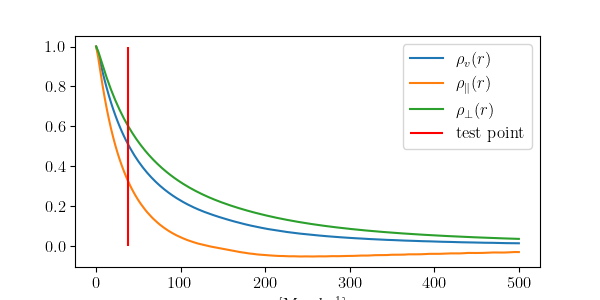

In [39]:
xi_v_arr = np.asarray([xi_v(r) for r in r_arr])
xi_para_arr = np.asarray([xi_para(r) for r in r_arr])
xi_perp_arr = np.asarray([xi_perp(r) for r in r_arr])

vbarsq = xi_v_arr[0] / 3
rho_v_arr = xi_v_arr / 3 / vbarsq
rho_para_arr = xi_para_arr / vbarsq
rho_perp_arr = xi_perp_arr / vbarsq

idx_temp = 15
rho_v = [rho_v_arr[idx_temp]]
rho_para = [rho_para_arr[idx_temp]]
rho_perp = [rho_perp_arr[idx_temp]]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(r_arr, rho_v_arr, label=r'$\rho_v(r)$')
ax.plot(r_arr, rho_para_arr, label=r'$\rho_\parallel(r)$')
ax.plot(r_arr, rho_perp_arr, label=r'$\rho_\perp(r)$')
ax.vlines(r_arr[idx_temp], 0, 1, color='r', label=r'test point')
ax.legend()
ax.set_xlabel(r'$r\,[\mathrm{Mpc}\,h^{-1}]$')

## Plot PDF

In [40]:
X_arr = np.geomspace(0.000001, 20, 200)
Y_arr = np.geomspace(0.000001, 20, 200)

P_X_Y_arr = P_X_Y(X_arr, Y_arr, rho_para, rho_perp)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


In [43]:
# rho_para_temp = rho_para[15]
# rho_perp_temp = rho_perp[15]
# P_X_Y_arr_temp = P_X_Y(X_arr, Y_arr, rho_para_temp, rho_perp_temp)
P_X_Y_arr_temp = P_X_Y_arr[0, :, :]
trapezoid(trapezoid(P_X_Y_arr_temp, x=Y_arr), x=X_arr)

np.float64(1.0000201945952651)

In [44]:
simpson(simpson(P_X_Y_arr_temp, x=Y_arr), x=X_arr)

np.float64(0.9976371248733708)

/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_14896/881612530.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  slider = Slider(


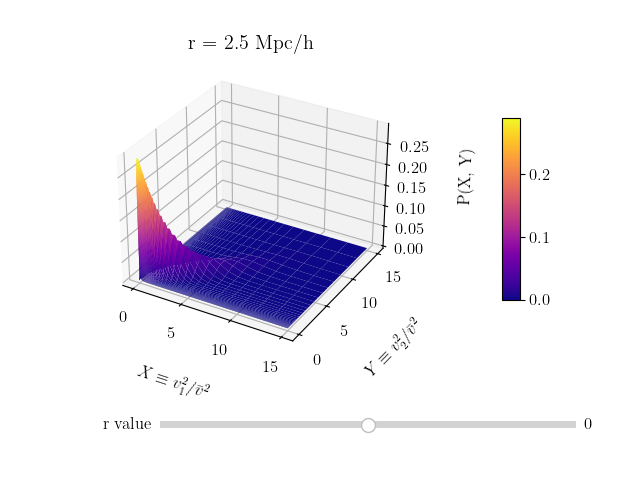

In [38]:
%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.subplots_adjust(bottom=0.25)  # Make room for the slider

X_mesh, Y_mesh = np.meshgrid(X_arr, Y_arr)
n_r = P_X_Y_arr.shape[0]

initial_idx = 0
stride = 1
surf = ax.plot_surface(X_mesh, Y_mesh, P_X_Y_arr[initial_idx, :, :], 
                       cmap='plasma', rstride=stride, cstride=stride)

ax.set_xlabel(r'$X\equiv v_1^2/\bar v^2$', labelpad=15)
ax.set_ylabel(r'$Y\equiv v_2^2/\bar v^2$', labelpad=15)
ax.set_zlabel('P(X, Y)', labelpad=15)
ax.set_title(f'r = {r_arr[idx_temp]:.1f} Mpc/h')
fig.colorbar(surf, shrink=0.6, aspect=10, pad=0.2)

ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])

slider = Slider(
    ax=ax_slider,
    label='r value',
    valmin=0,
    valmax=n_r - 1,
    valinit=initial_idx,
    valstep=1  # Snap to integer indices
)

def update(val):
    idx = int(slider.val)
    ax.cla()
    surf = ax.plot_surface(X_mesh, Y_mesh, P_X_Y_arr[idx, :, :], 
                           cmap='plasma', rstride=stride, cstride=stride)

    ax.set_xlabel(r'$X\equiv v_1^2/\bar v^2$', labelpad=15)
    ax.set_ylabel(r'$Y\equiv v_2^2/\bar v^2$', labelpad=15)
    ax.set_zlabel('P(X, Y)', labelpad=15)
    # ax.set_title(f'r = {r_arr[idx]:.1f} Mpc/h')
    ax.set_title(f'r = {r_arr[idx_temp]:.1f} Mpc/h')
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()

### Difference between isotropic and anisotropic

In [70]:
P_X_Y_iso_arr = P_X_Y(X_arr, Y_arr, rho_v, rho_v)
P_X_Y_diff_arr = P_X_Y_arr - P_X_Y_iso_arr
P_X_Y_frac_arr = P_X_Y_diff_arr / P_X_Y_iso_arr

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


/var/folders/b4/hg5l8r9915b4cr385qb8sfdw0000gn/T/ipykernel_6217/1146321025.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  slider = Slider(


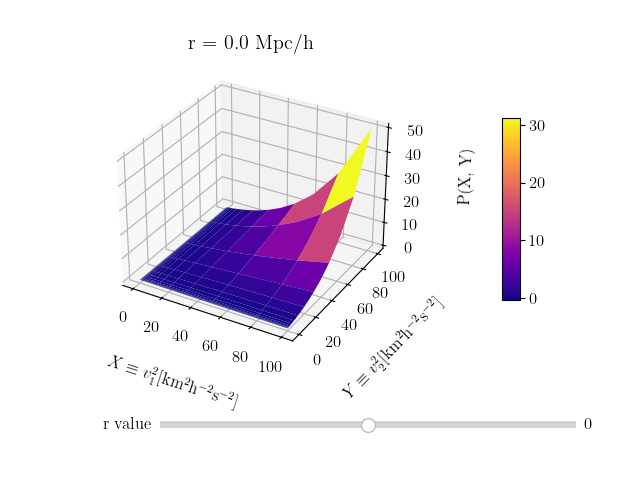

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.subplots_adjust(bottom=0.25)  # Make room for the slider

X_mesh, Y_mesh = np.meshgrid(X_arr, Y_arr)
n_r = P_X_Y_arr.shape[0]

initial_idx = 0
stride = 2
surf = ax.plot_surface(X_mesh, Y_mesh, P_X_Y_frac_arr[initial_idx, :, :], 
                       cmap='plasma', rstride=stride, cstride=stride)

ax.set_xlabel(r'$X\equiv v_1^2\mathrm{[km^2 h^{-2} s^{-2}]}$', labelpad=15)
ax.set_ylabel(r'$Y\equiv v_2^2\mathrm{[km^2 h^{-2} s^{-2}]}$', labelpad=15)
ax.set_zlabel('P(X, Y)', labelpad=15)
ax.set_title(f'r = {r_arr[initial_idx]:.1f} Mpc/h')
fig.colorbar(surf, shrink=0.6, aspect=10, pad=0.2)

ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])

slider = Slider(
    ax=ax_slider,
    label='r value',
    valmin=0,
    valmax=n_r - 1,
    valinit=initial_idx,
    valstep=1  # Snap to integer indices
)

def update(val):
    idx = int(slider.val)
    ax.cla()
    surf = ax.plot_surface(X_mesh, Y_mesh, P_X_Y_iso_arr[idx, :, :], 
                           cmap='plasma', rstride=stride, cstride=stride)
    
    ax.set_xlabel(r'$X\equiv v_1^2\mathrm{[km^2 h^{-2} s^{-2}]}$', labelpad=15)
    ax.set_ylabel(r'$Y\equiv v_2^2\mathrm{[km^2 h^{-2} s^{-2}]}$', labelpad=15)
    ax.set_zlabel('P(X, Y)', labelpad=15)
    ax.set_title(f'r = {r_arr[idx]:.1f} Mpc/h')
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()